# Preliminary Stuff #

In [3]:
import os
import pickle
import time
from datetime import datetime
         
import re
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

import numpy as np
import pandas as pd

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/black/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

The below cell loads the preprocessed and cleaned dataset. You may skip to "Generataing the Co-occurrence Matrix" Section

In [4]:
def load_data():
    with open("corpus.txt", "rb") as fp:
        corpus = pickle.load(fp)

    with open("vocabulary.txt", "rb") as fp:
        vocabulary = pickle.load(fp)

    with open("word2idx.txt", "rb") as fp:
        word2idx = pickle.load(fp)

    with open("idx2word.txt", "rb") as fp:
        idx2word = pickle.load(fp)
        
    return corpus, vocabulary, word2idx, idx2word
        
corpus, vocabulary, word2idx, idx2word = load_data()


#     NOTE : Skip to "Generating Co-occurrence Matrix" section.


# Generating the Dataset # 

In [ ]:
def clean_sentence(sentence):
    '''
    Clens the sentence, removing stopwords, symbols and numeric values.
    Also breaks the sentence down into tokens.
    All words are conveerted into lowercase.
    '''

    stop_words = set(stopwords.words('english'))
    stop_words.add('br')

    tokens = re.findall(r"[\w]+", sentence)
    filtered_tokens = [token for token in tokens if not token in stop_words]
    filtered_tokens = [token.lower() for token in filtered_tokens]
    filtered_tokens = [token.translate(token.maketrans("","", ".,:;''<>{}()[]_1234567890?")) for token in filtered_tokens]

    return filtered_tokens

sentence = "This is a 'sample' sentence... to _verify_ the 99th <br /><br />function!"
clean_sentence(sentence)

### MAKING THE CORPUS : ###  
* The corpus may be generated using .any combination of `test`/`train` and `pos`/`neg` folders.
* `dummy` contains a dummy dataset for model inspection.
* `sample`[x] contains a subset of the whole dataset with 'x' different files. 

In [ ]:
### MAKING THE CORPUS ###

folder_list = [
                #os.path.join("data","dummy")
                #os.path.join("data","sample20"),
                #os.path.join("data","sample50"),
                #os.path.join("data","sample250"),
                os.path.join("data","sample1000"),
                #os.path.join("data","test","neg"),
                #os.path.join("data","test","pos"),
                #os.path.join("data","train","neg"),
                #os.path.join("data","train","pos")
              ]

corpus = []

for folder in folder_list:
    file_list = os.listdir(folder)

    for file in file_list:
        file_path = os.path.join(folder,file)
        file_content = open(file_path,encoding='utf8')
        data = file_content.read()
        clean_data = clean_sentence(data)
        corpus.append(clean_data)

In [ ]:
### MAKING THE VOCABULARY ###

vocabulary = []

for sentence in corpus:
    for token in sentence:
        if token not in vocabulary:
            vocabulary.append(token)

vocabulary.sort()
vocab_size = len(vocabulary)

word2idx = {w: idx for (idx, w) in enumerate(vocabulary)}
idx2word = {idx: w for (idx, w) in enumerate(vocabulary)}

# Generating Co-occurrence Matrix #

In [5]:
### MAKING THE CO-OCCURRENCE MATRIX ###


window_size = 10
vocab_size = len(vocabulary)

    
X = np.zeros((vocab_size,vocab_size))

for token_list in corpus:
    token_count = len(token_list)

    for token_index, token in enumerate(token_list):
        left = max(0,token_index-window_size)
        right = min(token_count,token_index+window_size+1)
        context_tokens_idx = [idx for idx in range(left,right) if idx != token_index]
        context_tokens = [token_list[idx] for idx in context_tokens_idx]

        #print(token)
        #print(context_tokens)

        for context_token in context_tokens: 
            vocab_index_centre = word2idx[token]
            vocab_index_context = word2idx[context_token]

            X[vocab_index_centre][vocab_index_context] += 1

# Some Useful Functions #

In [6]:
def print_time(time_begin, time_end):
    FMT = '%H:%M:%S'
    td = (datetime.strptime(time_end[11:19], FMT) - datetime.strptime(time_begin[11:19], FMT)).seconds
    hr = (td//3600)
    min = (td - 3600*hr)//60
    sec = (td - 3600*hr - 60*min)
    print("Time taken : {:2.0f}:{:2.0f}:{:2.0f}".format(hr,min,sec))

In [7]:
def get_sim_val(a1,a2,b1,b2):
    '''
    Returns a real number that measures how well the relation a1:a2::b1:b2 holds for some words.
    Lower is better.
    '''

    sim_vec = (U[word2idx[a1]] - U[word2idx[a2]] / U[word2idx[b1]] - U[word2idx[b2]])
    sim = np.sqrt(np.mean(abs(sim_vec - sim_vec.mean())**2))
    return sim

def measure_progress():
    '''
    Aggregates word similarities for a set of words.
    Reports that as a measure of model performance.
    Lower is better.
    '''
    
    val=0
    v1 = get_sim_val("king", "queen", "man", "woman")
    v2 = get_sim_val("king", "queen", "boy", "girl")
    v3 = get_sim_val("boy", "girl", "man", "woman")
    val = v1+v2+v3
    
    print("Similarity Value : {:.5f}".format(val))
    #print("v1,v2,v3 : {:.5f}, {:.5f}, {:.5f}".format(v1,v2,v3))
    
    return val
    
#measure_progress()

# Initializing the Model #

In [8]:
print(len(corpus))
print(vocab_size)
print(vocab_size ** 2)

1000
15958
254657764


In [9]:
# Dimension of generated word vector
dimension = 15

# Embedding Matrix for Main word
U = (np.random.rand(vocab_size, dimension) - 0.5) / float(dimension + 1)

# Embedding Matrix for Context word
V = (np.random.rand(vocab_size, dimension) - 0.5) / float(dimension + 1)

# Bias for Main Word
bu = (np.random.rand(vocab_size).reshape(-1,1) - 0.5) / float(dimension + 1)    

# Bias for Context Word
bv = (np.random.rand(vocab_size).reshape(-1,1) - 0.5) / float(dimension + 1)   

iter_list = []
cost_list = []

In [10]:
#def train_glove(vocabulary, training_samples, dimension=5, iterations=10, learning_rate=0.01):

iterations = 50
learning_rate = 0.001

# Training the Model #

In [11]:
### Load a pretrained model ###

with open("params.txt", "rb") as fp:
    params = pickle.load(fp)

with open("monitering_lists.txt", "rb") as fp:
    monitering_lists = pickle.load(fp)

U,V,bu,bv = params
iter_list, cost_list = monitering_lists
iteration = iter_list[-1]

In [ ]:
def get_weight(x_ij, x_max=100, alpha=.75):
    if(x_ij < x_max):
        return (x_ij/x_max) ** alpha
    else: return 1

In [ ]:
### Train the model ###

total_iteration = iteration + iterations
print("Beginning Training...")

for i in range(iterations):
    time_begin = time.asctime()

    print("-------------------------------------------")
    iteration += 1
    cost = 0

    for i in range(vocab_size):
        for j in range(vocab_size):
            x_ij = X[i][j] 
            loss = 0

            if(x_ij!= 0): 

                w = get_weight(x_ij)
                loss_in = (np.dot(U[i],V[j]) + bu[i] + bv[i] - np.log(x_ij)).item()         

                loss = w * (loss_in**2)
                cw = w * loss_in

                U[i] = U[i] - learning_rate * (cw * V[j])
                V[j] = V[j] - learning_rate * (cw * U[i])
                bu[i:i+1] = bu[i:i+1] - (learning_rate * cw)
                bv[j:j+1] = bv[j:j+1] - (learning_rate * cw)
                
                cost += loss
                #print(i,j,x_ij, loss_in, loss)

            else: 
                flag=0
    
    iter_list.append(iteration)
    cost_list.append(cost)
    
    print("Iteration  : {}/{}".format(iteration,total_iteration))
    print("Cost       : {:.5f}".format(cost))
    
    time_end = time.asctime()
    print_time(time_begin, time_end)
    sim = measure_progress()
    print("-------------------------------------------")
print("Done.")

# Making the TSNE Vectors # 

In [12]:
### Import the saved TSNE Vectors ### 
    
with open("tsne_vecs.txt", "rb") as fp:
        tsne_vecs = pickle.load(fp)   

In [ ]:
### Build TSNE Vectors ###

def build_tsne_vecs(U,V):    
    '''
    Returns TSNE vecots given Matrices U and V.
    '''
    
    tsne_vecs = TSNE().fit_transform((U+V)/2)
    print(tsne_vecs.shape)
    return tsne_vecs

#tsne_vecs = build_tsne_vecs(U,V)

# Visualising the Results # 

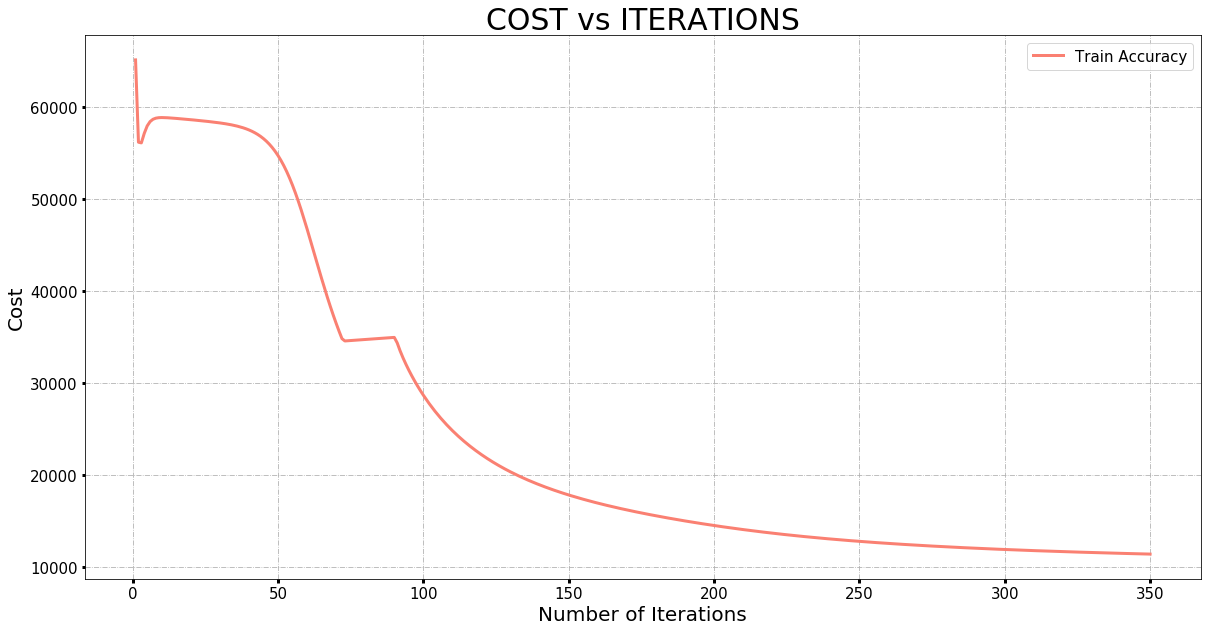

In [13]:
### Plot the Accuracy Graph ###

plt.figure(figsize=[20,10])

plt.plot(iter_list, cost_list, '-', lw=3, c='salmon', label='Train Accuracy')

plt.title('COST vs ITERATIONS', size='30')
plt.xlabel('Number of Iterations', size='20')
plt.ylabel('Cost', size='20')

plt.grid(True, linestyle='-.',)
plt.tick_params(labelcolor='k', labelsize='15', width=3)

plt.legend(fontsize='15')

fig1 = plt.gcf()
plt.show()

fig1.savefig('cost_vs_iterations.png', dpi=50)


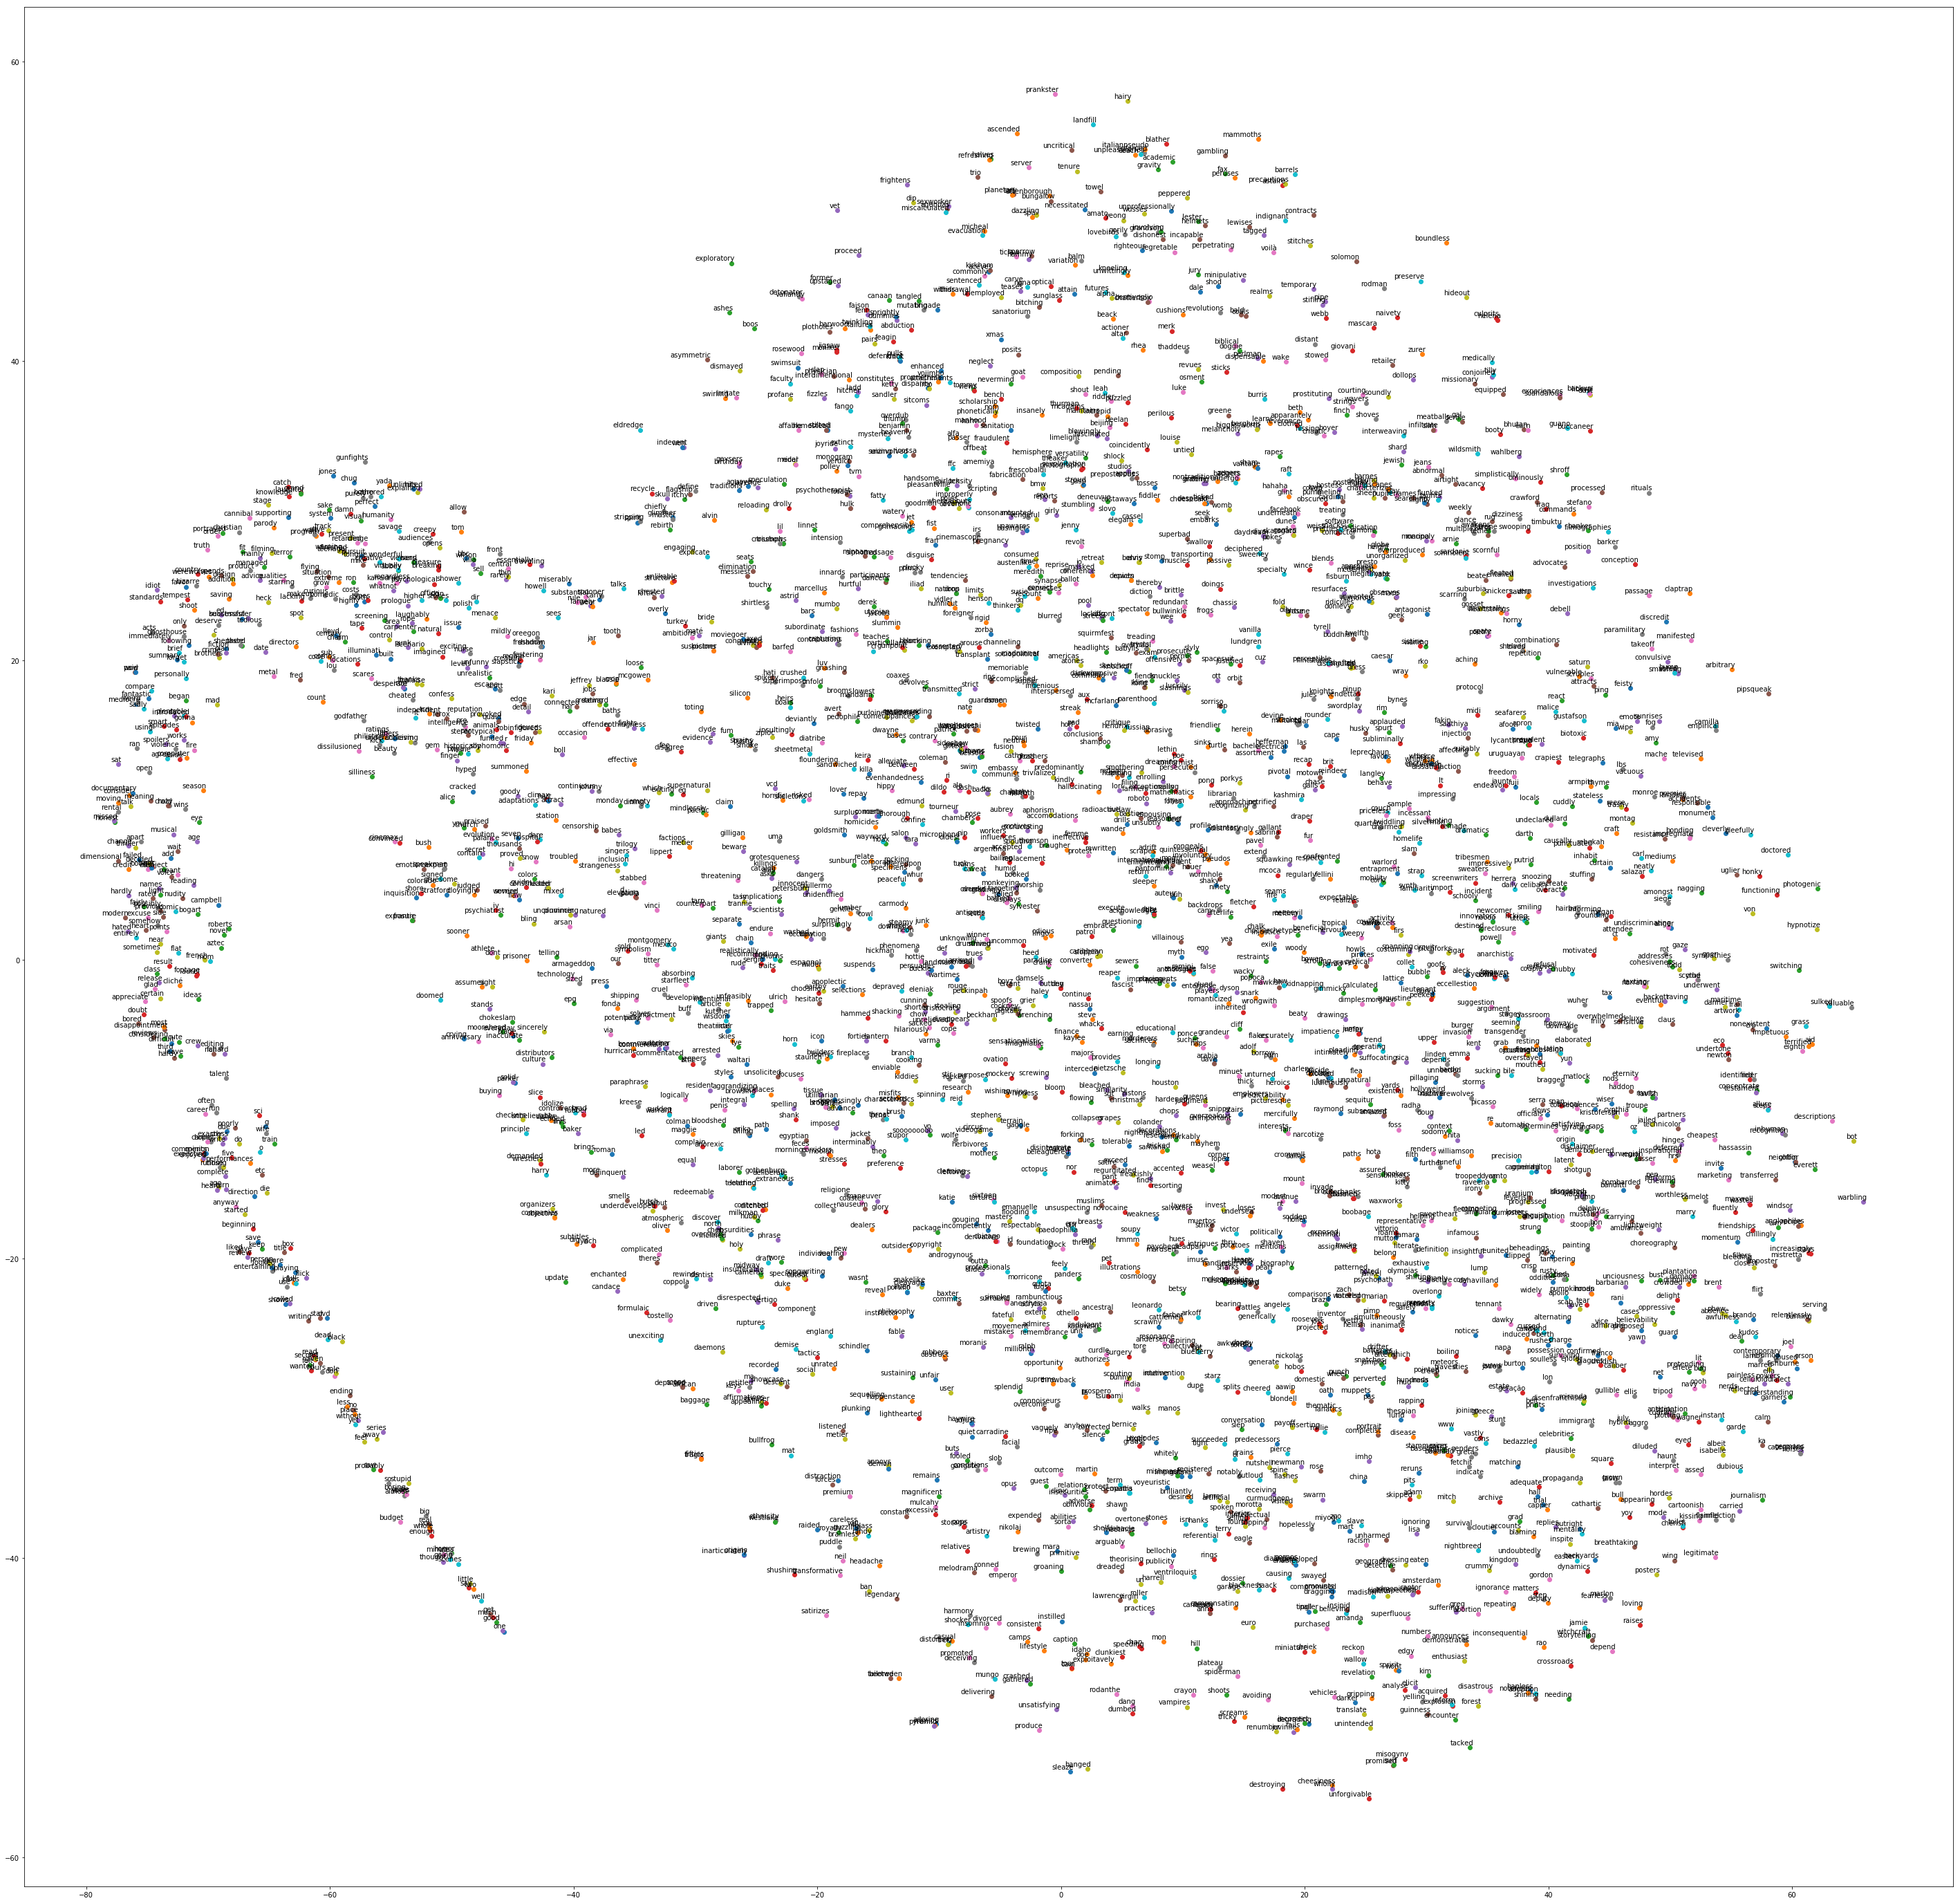

<Figure size 432x288 with 0 Axes>

In [24]:
### Visualise the Word Vecotrs ###

x = []
y = []

for point in tsne_vecs:
    x.append(point[0])
    y.append(point[1])

plt.figure(figsize=(50,50)) 


for i in range(0,vocab_size,5):
    plt.scatter(x[i],y[i])
    plt.annotate(idx2word[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
    
plt.show()

ref = plt.gcf()
ref.savefig('tsne, iter=350, dpi=100, words=allby5.png', dpi=100)

# Save the Model #

In [23]:
### Save data ###

def save(flag=1):

    if(flag==0):
        with open("corpus.txt", "wb") as fp:
            pickle.dump(corpus, fp)

        with open("vocabulary.txt", "wb") as fp:
            pickle.dump(vocabulary, fp)

        with open("word2idx.txt", "wb") as fp:
            pickle.dump(word2idx, fp)

        with open("idx2word.txt", "wb") as fp:
            pickle.dump(idx2word, fp)
            
    if(flag==1):
        params = [U,V,bu,bv]
        monitering_lists = [iter_list, cost_list]
    
        with open("params.txt", "wb") as fp:
            pickle.dump(params, fp)

        with open("monitering_lists.txt", "wb") as fp:
            pickle.dump(monitering_lists, fp)
    
    if(flag==2):
        with open("tsne_vecs.txt", "wb") as fp:
            pickle.dump(tsne_vecs, fp)
    
save(0)
save(1)
save(2)